In [ ]:
# Install any packages if needed
# (most are already available in Colab; seaborn/pydot optional)
!pip install --quiet geopandas > /dev/null || true

# Cell 2: Imports
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files, drive
%matplotlib inline

plt.rcParams['figure.figsize'] = (12,6)


In [ ]:
# load from runtime path (if file already uploaded to /mnt/data)
path = "/mnt/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
if os.path.exists(path):
    df = pd.read_csv(path)
    print("Loaded from", path)
else:
    # fallback to interactive upload in Colab
    from google.colab import files
    uploaded = files.upload()
    fn = list(uploaded.keys())[0]
    df = pd.read_csv(fn)
    print("Uploaded & loaded", fn)

df.shape, df.columns.tolist()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
Uploaded & loaded WA_Fn-UseC_-Telco-Customer-Churn.csv


((7043, 21),
 ['customerID',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges',
  'Churn'])

In [ ]:
#  quick peek
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#  summary
print("Rows,Cols:", df.shape)
print("\nMissing values per column:")
print(df.isna().sum())
print("\nData types:")
print(df.dtypes.value_counts())


Rows,Cols: (7043, 20)

Missing values per column:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Data types:
object     16
int64       2
float64     2
Name: count, dtype: int64


In [ ]:
# example cleaning steps common to Telco churn
# Convert total charges that may be spaces into numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop customerID if present (identifier)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Check duplicates
print("Duplicate rows:", df.duplicated().sum())

# Look at churn distribution
if 'Churn' in df.columns:
    print("\nChurn value counts:\n", df['Churn'].value_counts())


Duplicate rows: 22

Churn value counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


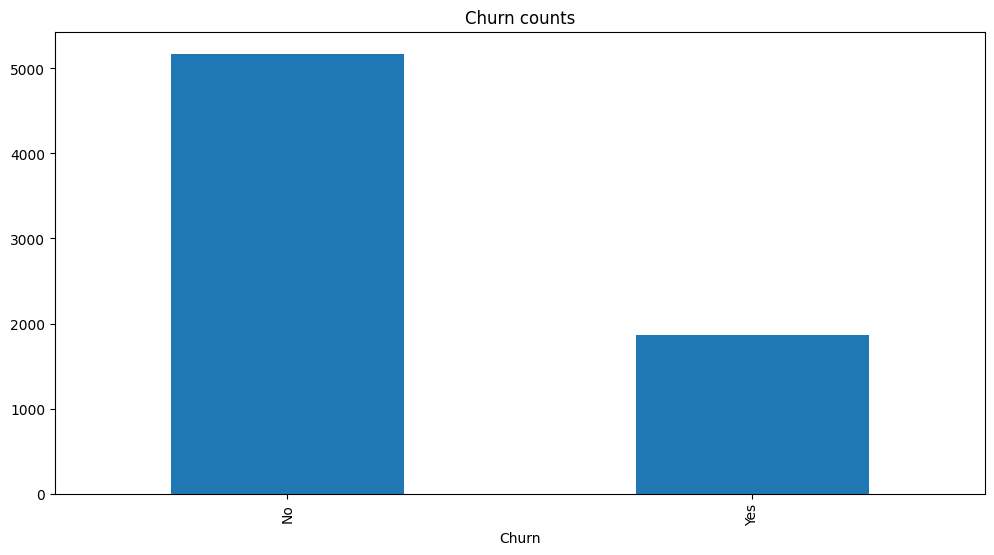

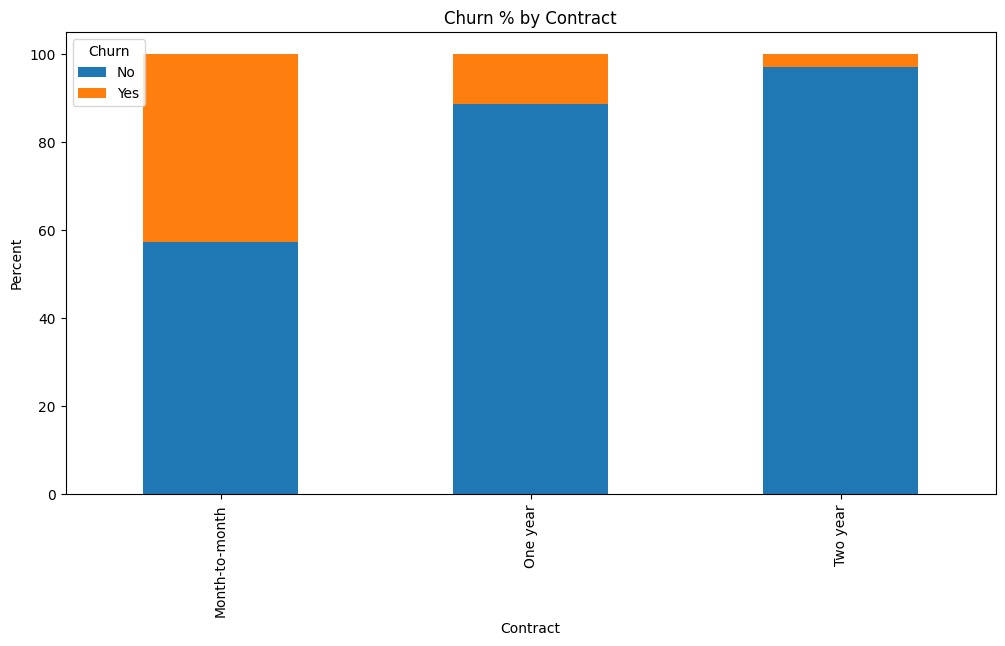

In [ ]:
# : simple visualizations
import matplotlib.pyplot as plt

# Churn bar chart
if 'Churn' in df.columns:
    df['Churn'].value_counts().plot(kind='bar', title='Churn counts')
    plt.show()

# Example: Contract type vs churn if present
if 'Contract' in df.columns:
    ct = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, title='Churn % by Contract')
    plt.ylabel('Percent')
    plt.show()


In [ ]:
# preprocess
!pip install category_encoders
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

# Separate X, y
target = 'Churn'
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in dataframe.")

X = df.drop(columns=[target]).copy()
y = df[target].map({'Yes':1, 'No':0})  # adapt to Yes/No

# Identify categorical vs numeric
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

# Impute numeric
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# For categorical: fill missing and use ordinal/one-hot or target encoding.
# Use TargetEncoder (category_encoders) for many categories to keep dimension manageable
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# Target encoding (safer than naive label for nominal)
te = ce.TargetEncoder(cols=cat_cols)
X[cat_cols] = te.fit_transform(X[cat_cols], y)

# Scale numeric features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (5634, 19) Test: (1409, 19)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

#train baseline RF
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict & metrics
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC AUC: 0.8246247642667079
Confusion matrix:
 [[926 109]
 [185 189]]


TotalCharges        0.189774
MonthlyCharges      0.171758
tenure              0.155872
Contract            0.078376
PaymentMethod       0.054923
OnlineSecurity      0.046166
TechSupport         0.038283
InternetService     0.034728
gender              0.028477
OnlineBackup        0.025727
PaperlessBilling    0.025567
MultipleLines       0.023576
DeviceProtection    0.022499
Partner             0.022303
SeniorCitizen       0.020066
StreamingMovies     0.019634
Dependents          0.018960
StreamingTV         0.018903
PhoneService        0.004408
dtype: float64


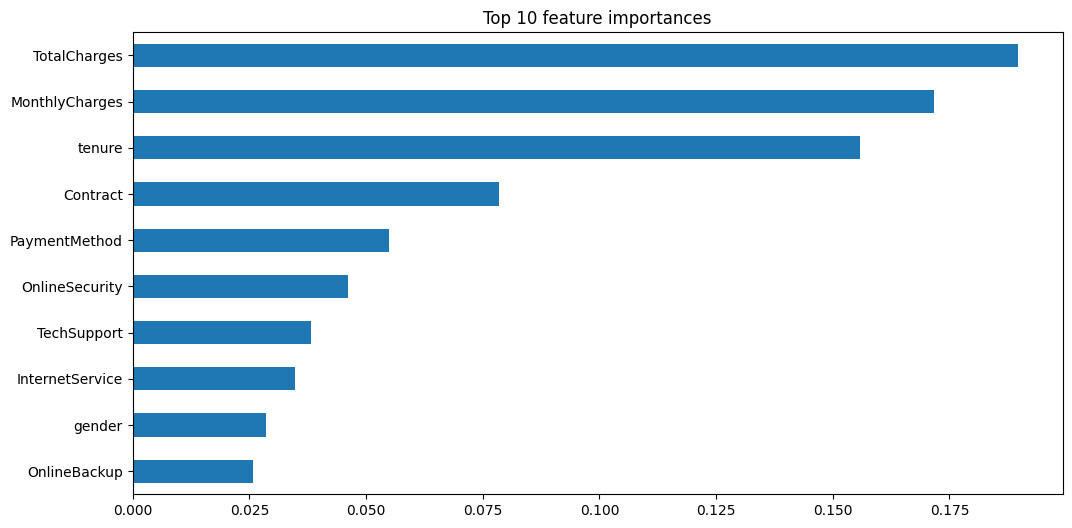

In [ ]:
# feature importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feat_imp.head(20))

# Plot top 10
feat_imp.head(10).plot(kind='barh', title='Top 10 feature importances')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# optional grid search (takes time)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12, None],
    'min_samples_split': [2, 5]
}
gcv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                   param_grid, cv=3, scoring='roc_auc', verbose=1)
gcv.fit(X_train, y_train)
print("Best params:", gcv.best_params_)
best_rf = gcv.best_estimator_

# Evaluate best
y_prob_best = best_rf.predict_proba(X_test)[:,1]
print("Best ROC AUC:", roc_auc_score(y_test, y_prob_best))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 200}
Best ROC AUC: 0.8440866465163139


In [ ]:
import joblib
#  save model + encoders + scaler + imputers + feature list
model_artifacts = {
    'model': rf,           # or best_rf if you used gridsearch
    'num_imputer': num_imputer,
    'cat_imputer': cat_imputer,
    'target_encoder': te,
    'scaler': scaler,
    'feature_columns': X.columns.tolist()
}
joblib.dump(model_artifacts, 'telco_churn_artifacts.pkl')
print("Saved artifacts to telco_churn_artifacts.pkl")

Saved artifacts to telco_churn_artifacts.pkl


In [ ]:
from google.colab import files
files.download('telco_churn_artifacts.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#  single-record inference sample
# Example: take first row from X_test as a single-record example
example = X_test.iloc[0:1].copy()   # shape (1, n_features)

# IMPORTANT: When using preprocessing saved artifacts, reapply same transforms to raw row.
# If you only have encoded/scaled X already, pass the row directly to model.predict_proba.
# If you have raw data, you must re-run imputation/encoding/scaling in same order as training.

proba = rf.predict_proba(example)[:,1][0]
print("Predicted churn probability:", proba)


Predicted churn probability: 0.005


In [ ]:
# robust single-row inference
example_raw = df.drop(columns=[target]).iloc[5:6].copy()  # raw row (not preprocessed)
# Reapply imputers/encoders/scaler in same order:
example_raw[num_cols] = num_imputer.transform(example_raw[num_cols])
example_raw[cat_cols] = cat_imputer.transform(example_raw[cat_cols])
example_raw[cat_cols] = te.transform(example_raw[cat_cols])
example_raw[num_cols] = scaler.transform(example_raw[num_cols])
example_prepared = example_raw[X_train.columns]  # ensure column order

proba = rf.predict_proba(example_prepared)[:,1][0]
print("Predicted churn probability:", proba)


Predicted churn probability: 0.98
